### Credenciais de Acesso Kaggle

In [1]:
{"username":"jcss03","key":"caf02cc87bdafff295f9eb6897072757"}

{'username': 'jcss03', 'key': 'caf02cc87bdafff295f9eb6897072757'}

### Imports

In [2]:
!pip install opendatasets
!pip install pandas

import opendatasets as od
import pandas
# utilities
import re
import numpy as np
import pandas as pd
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
from nltk.stem import WordNetLemmatizer
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

import re

from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


### Download Dataset

In [3]:
# download data from kaggle
od.download("https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis/download?datasetVersionNumber=2")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: jcss03
Your Kaggle Key: ··········


100%|██████████| 1.99M/1.99M [00:00<00:00, 82.8MB/s]

In [4]:
# caminho para o dataset
!ls ./twitter-entity-sentiment-analysis

twitter_training.csv  twitter_validation.csv


### Acesso ao Drive

In [5]:
# Acesso a pasta do drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [6]:
# exemplo
!ls /content/drive/MyDrive/'Trabalho de Graduação'/scripts

data			    model_embeddings.ipynb  word_embeddings.ipynb
Exploratory_Analysis.ipynb  model_word2vec.ipynb
model_BoW-tf-idf.ipynb	    Processing_text.ipynb


### Loading Datasets
* Train
* Test

In [7]:
dataset_train = pd.read_csv('./twitter-entity-sentiment-analysis/twitter_training.csv',names=['Tweet_ID','entity','sentiment','Tweet content'],header=None)
dataset_validation = pd.read_csv('./twitter-entity-sentiment-analysis/twitter_validation.csv',names=['Tweet_ID','entity','sentiment','Tweet content'],header=None)

In [8]:
print('Exemplo do dataset')
dataset_train.sample(5)

Exemplo do dataset


,Tweet_ID,entity,sentiment,Tweet content
65069,7944,MaddenNFL,Negative,BYE AM y’all done
51839,10504,RedDeadRedemption(RDR),Positive,now is a excellent time to actually go try & f...
53195,10739,RedDeadRedemption(RDR),Neutral,<unk> Dead Redemption 2008. Horses for Courses...
68921,3803,Cyberpunk2077,Neutral,"""Cyberpunk 2012: ""We aren't really pleased wit..."
10480,13003,Xbox(Xseries),Positive,Notes When first the PS4 player and Xbox One c...


#### Encodificar Targets

In [9]:
data = dataset_train[['Tweet content','sentiment']].rename(columns={"Tweet content": "text", "sentiment": "target"})
data.target = pd.Categorical(data.target)

data['code'] = data.target.cat.codes
print('#'*100)
print(f'Targets: {data.target.unique()}')
print(f'Codes: {data.code.unique()}')
print('#'*100)
data.sample(5)

####################################################################################################
Targets: ['Positive', 'Neutral', 'Negative', 'Irrelevant']
Categories (4, object): ['Irrelevant', 'Negative', 'Neutral', 'Positive']
Codes: [3 2 1 0]
####################################################################################################


,text,target,code
9751,youtu.be / SX1rqUVuXGM has a video on the Xbox...,Irrelevant,0
51172,First Fifa whom I like in a long long new time...,Positive,3
32961,my moms playing now and she understand even le...,Positive,3
59851,I am shocked that the majority of people on Fa...,Irrelevant,0
24015,Turkey is bloody mad dog state led to murderou...,Irrelevant,0


#### Remover valores Null

In [10]:
print('#'*100)
qtd_null_values = np.sum(data.isnull().any(axis=1))
print(f'Shape dos dados: {data.shape}')
print(f'Number null values = {qtd_null_values}')

# dropna values
data = data.dropna().reset_index(drop=True)

print('#'*100)
qtd_null_values = np.sum(data.isnull().any(axis=1))
print(f'Shape dos dados: {data.shape}')
print(f'Number null values = {qtd_null_values}')

####################################################################################################
Shape dos dados: (74682, 3)
Number null values = 686
####################################################################################################
Shape dos dados: (73996, 3)
Number null values = 0


### Processing Text
* stopwords
* punctuation
* Stemming(reducing the words to their derived stems)
* Lemmatization(reducing the derived words to their root form known as lemma)
* removing unnecessary characters
* lower case text to better generalization

In [11]:
# recebe texto e processa
def processing_text(text,flag_punctuation=False,flag_stopwords=False,flag_stem=False,flag_lemma=False):

  ##############################################################################
  # funções

  # maketrans explained - 'https://www.w3schools.com/python/ref_string_maketrans.asp'
  def cleaning_punctuations(text):
      english_punctuations = string.punctuation
      punctuations_list = english_punctuations

      translator = str.maketrans('', '', punctuations_list)
      return text.translate(translator)
  
  # remover stopwords
  def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    text = " ".join([word for word in text.split(' ') if word not in stop_words])
    return text

  # removendo chars repetidos
  def cleaning_repeating_char(text):
      return re.sub(r'(.)1+', r'1', text)

  # removing stem
  def stemming(text):
    ps = PorterStemmer()
    text = " ".join([ps.stem(word) for word in text.split(' ')])
    return text

  def lemmatizer(text):
      lm = nltk.WordNetLemmatizer()
      text = " ".join([lm.lemmatize(word) for word in text.split(' ')])
      return text
  ##############################################################################

  # Processing

  # lower all string of text
  text = re.sub(r'[^\w\s]', '', str(text).lower().strip())

  # remover pontuações
  if flag_punctuation:
    text = cleaning_punctuations(text)

  # remover stopwords
  if flag_stopwords:
    text = remove_stopwords(text)

  # remover repetições
  text = cleaning_repeating_char(text)

  # lenma
  if flag_lemma:
    text = lemmatizer(text)

  # stem:
  if flag_stem:
    text = stemming(text)

  return text

In [12]:
example = data.text.iloc[100]
example

'Grounded almost was pretty cool even despite the top tier unfunny writing until we became yet another annoying crafting game. I seriously can’t wait on this shitty trend to die'

In [13]:
clean_text = processing_text(example,flag_punctuation=True,flag_stopwords=True,flag_lemma=True)
clean_text

'grounded almost pretty cool even despite top tier unfunny writing became yet another annoying crafting game seriously cant wait shitty trend die'

In [14]:
# clean text
data['clean_text'] = data['text'].apply(lambda x: processing_text(x,flag_punctuation=True,flag_stopwords=True,flag_lemma=True))

In [15]:
data.sample(10)

,text,target,code,clean_text
55460,Calls from _ z1rv _ & @ Tweet98 got me this so...,Neutral,2,call 1rv tweet98 got sore as
28210,.. play.playstation.com/,Neutral,2,playplaystationcom
1026,"Keep your chin held up, or SO GO I CAN SMASH I...",Neutral,2,keep chin held go smash hammer chaotic digital...
68248,I CANNOT WAIT FOR THISSSSSSS,Positive,3,cannot wait thisssssss
67659,@ michalpg @ tostspender,Positive,3,michalpg tostspender
64488,MADDEN!!!! Don’t fuckin play around wit me!!!,Negative,1,madden dont fuckin play around wit
55409,anyone else with problems with,Negative,1,anyone else problem
3470,OH MY!.,Negative,1,oh
46923,BAHAHAHA!!!:.. RED ALERT!... RICH GUY SAYS HIS...,Irrelevant,0,bahahaha red alert rich guy say employment gun...
67218,0 @RongHeng U took my breath sucked away by fe...,Irrelevant,0,0 rongheng u took breath sucked away feeding s...


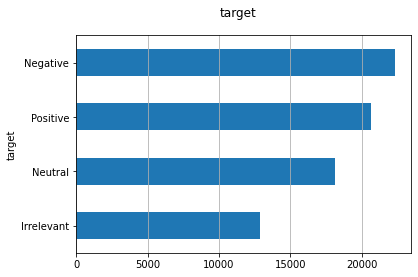

In [16]:
fig, ax = plt.subplots()
fig.suptitle("target", fontsize=12)
data["target"].reset_index().groupby("target").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

In [17]:
data = data[data.target != 'Irrelevant']


In [18]:
print(data.target.unique())
print(data.code.unique())


['Positive', 'Neutral', 'Negative']
Categories (4, object): ['Irrelevant', 'Negative', 'Neutral', 'Positive']
[3 2 1]


### Split dataset_train 
* train
* validation

In [19]:
from sklearn.model_selection import train_test_split

# split dataset
df_train, df_val = train_test_split(data[['code','clean_text']], test_size=0.3)
## get target
target_train = df_train["code"]
target_val = df_val["code"]

### Word2vec

In [26]:
import gensim

In [31]:
model = gensim.models.Word2Vec(window=10,min_count=2)

### Word Embeddings

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [ ]:
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(df_train['clean_text'])

word_index = tokenizer.word_index
print(len(word_index))

30320


In [ ]:
# Transformar as sentencas dos dados de treinamento e teste para sequencias numericas. ex [[1,2,6],[65,952,15,65],[1,2]]
train_data_sentences = tokenizer.texts_to_sequences(df_train['clean_text'])
val_data_sentences = tokenizer.texts_to_sequences(df_val['clean_text'])

# normalizar o tamnho das sequencias usando padding. ex [[0,1,2,6],[65,952,15,65],[0,0,1,2]]
train_padded = pad_sequences(train_data_sentences, maxlen=300)
val_padded = pad_sequences(val_data_sentences, maxlen=300)

print("Conjunto de treinamento: ","\n",train_padded[0:19])
print("Conjunto de validation: ","\n",val_padded[0:19])

Conjunto de treinamento:  
 [[   0    0    0 ...  295  704   21]
 [   0    0    0 ...    5   11 8654]
 [   0    0    0 ... 3670 7055 3497]
 ...
 [   0    0    0 ... 7058 8655  170]
 [   0    0    0 ...  618 1284  289]
 [   0    0    0 ...  849 5283  727]]
Conjunto de validation:  
 [[    0     0     0 ...   138   276   175]
 [    0     0     0 ...   181   271     1]
 [    0     0     0 ...  3343   440  1916]
 ...
 [    0     0     0 ... 10673    48    88]
 [    0     0     0 ...   101    64 25333]
 [    0     0     0 ...     0   603   628]]


### Models

#### Random Forest

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble  import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import mean_squared_error , accuracy_score

In [ ]:
model_randomForest = RandomForestClassifier(random_state=50,criterion='gini')
model_randomForest.fit(train_padded,target_train)

RandomForestClassifier(random_state=50)

In [ ]:
predicaoTrain = model_randomForest.predict(train_padded)
predicaoVal = model_randomForest.predict(val_padded)

print("ACC TRAINING:" + str(accuracy_score(target_train, predicaoTrain)))
print("ACC Validation:" + str(accuracy_score(target_val, predicaoVal)))

ACC TRAINING:0.9782629020194465
ACC Validation:0.6570867644652888


### Deep Learning

In [ ]:
col_bytes_len = int(df_train['clean_text'].str.len().max())
type(col_bytes_len)

int

In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = int(df_train['clean_text'].str.len().max())
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS,oov_token='<OOV>')
tokenizer.fit_on_texts(df_train['clean_text'])

word_index = tokenizer.word_index
print(len(word_index))

# Transformar as sentencas dos dados de treinamento e teste para sequencias numericas. ex [[1,2,6],[65,952,15,65],[1,2]]
train_data_sentences = tokenizer.texts_to_sequences(df_train['clean_text'])
val_data_sentences = tokenizer.texts_to_sequences(df_val['clean_text'])

# normalizar o tamnho das sequencias usando padding. ex [[0,1,2,6],[65,952,15,65],[0,0,1,2]]
train_padded = pad_sequences(train_data_sentences, maxlen=MAX_SEQUENCE_LENGTH)
val_padded = pad_sequences(val_data_sentences, maxlen=MAX_SEQUENCE_LENGTH)

print("Conjunto de treinamento: ","\n",train_padded[0:19])
print("Conjunto de validation: ","\n",val_padded[0:19])

30320
Conjunto de treinamento:  
 [[   0    0    0 ...  295  704   21]
 [   0    0    0 ...    5   11 8654]
 [   0    0    0 ... 3670 7055 3497]
 ...
 [   0    0    0 ... 7058 8655  170]
 [   0    0    0 ...  618 1284  289]
 [   0    0    0 ...  849 5283  727]]
Conjunto de validation:  
 [[    0     0     0 ...   138   276   175]
 [    0     0     0 ...   181   271     1]
 [    0     0     0 ...  3343   440  1916]
 ...
 [    0     0     0 ... 10673    48    88]
 [    0     0     0 ...   101    64 25333]
 [    0     0     0 ...     0   603   628]]


In [ ]:
print(df_train['clean_text'].shape,target_train.shape)
print(df_val['clean_text'].shape,target_val.shape)

(42784,) (42784,)
(18337,) (18337,)


In [ ]:
print(train_padded.shape,target_train.shape)
print(val_padded.shape,target_val.shape)

(42784, 596) (42784,)
(18337, 596) (18337,)


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
OUTPUT_UNITS = 3 # num of out put units (classes/labels/notas musicais)

In [ ]:
model = keras.Sequential()
model.add(layers.Embedding(MAX_NB_WORDS,EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dense(24,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
history = model.fit(train_padded, target_train, epochs=5, validation_data=(val_padded,target_val),verbose=1)

Epoch 1/5
1337/1337 [==============================] - 90s 67ms/step - loss: -6998.0068 - accuracy: 0.3670 - val_loss: -23307.0449 - val_accuracy: 0.3630
Epoch 2/5
1337/1337 [==============================] - 90s 67ms/step - loss: -64873.5977 - accuracy: 0.3670 - val_loss: -121903.6797 - val_accuracy: 0.3630
Epoch 3/5
1337/1337 [==============================] - 69s 51ms/step - loss: -210159.3594 - accuracy: 0.3670 - val_loss: -317325.0625 - val_accuracy: 0.3630
Epoch 4/5
1337/1337 [==============================] - 70s 52ms/step - loss: -459348.2812 - accuracy: 0.3670 - val_loss: -624502.8750 - val_accuracy: 0.3630
Epoch 5/5
1337/1337 [==============================] - 67s 50ms/step - loss: -827164.2500 - accuracy: 0.3670 - val_loss: -1057907.6250 - val_accuracy: 0.3630
